In [1]:
# This line makes me sad, but is temporarily necessary to see task output 😔
import lsst.daf.butler.cli.cliLog as cliLog
cliLog.CliLog.initLog(longlog=False)

In [2]:
import lsst.daf.butler as dafButler
collections = ['LATISS/raw/all',
               'u/czw/DM-28920/calib.20210720']
butler = dafButler.Butler('/repo/main', instrument='LATISS', collections=collections)

In [3]:
dataId = {'day_obs': 20210727, 'seq_num': 26, 'detector': 0}

In [4]:
exp = butler.get('raw', **dataId)

obs.lsst.assembly WARNING: (minimum=(0, 0), maximum=(543, 2047)): (minimum=(0, 0), maximum=(575, 2047))


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 720x720 with 0 Axes>

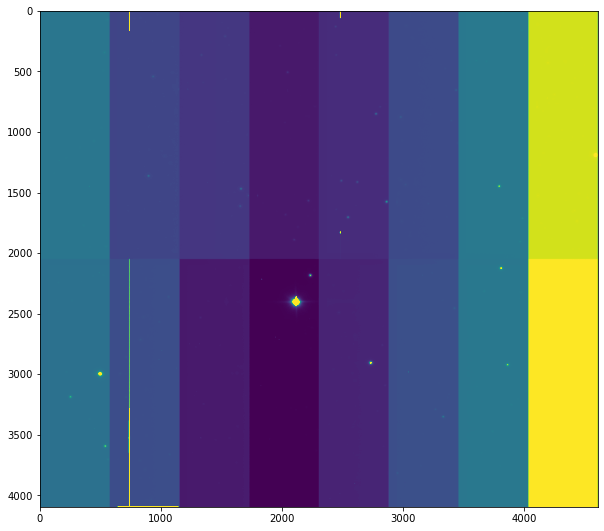

In [6]:
plt.figure(figsize=(10,10))
data = exp.image.array
plt.imshow(data, vmin=np.percentile(data, 2),vmax=np.percentile(data, 98))

In [7]:
del(exp)

In [8]:
from lsst.ip.isr.isrTask import IsrTask
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = False
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doWrite = False

isrTask = IsrTask(config=isrConfig)

In [9]:
raw = butler.get('raw', **dataId)
bias = butler.get('bias', **dataId)
defects = butler.get('defects', **dataId)

obs.lsst.assembly WARNING: (minimum=(0, 0), maximum=(543, 2047)): (minimum=(0, 0), maximum=(575, 2047))


In [10]:
postIsr = isrTask.run(raw, bias=bias, defects=defects).exposure

isr INFO: Converting exposure to floating point values.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Applying bias correction.
isr INFO: Masking non-finite (NAN, inf) value pixels.
isr INFO: Widening saturation trails.
isr INFO: Interpolating masked pixels.
isr WARNING: No rough magnitude zero point defined for filter RG610~empty.
isr INFO: Setting rough magnitude zero point for filter RG610~empty: 29.747425


<Figure size 720x720 with 0 Axes>

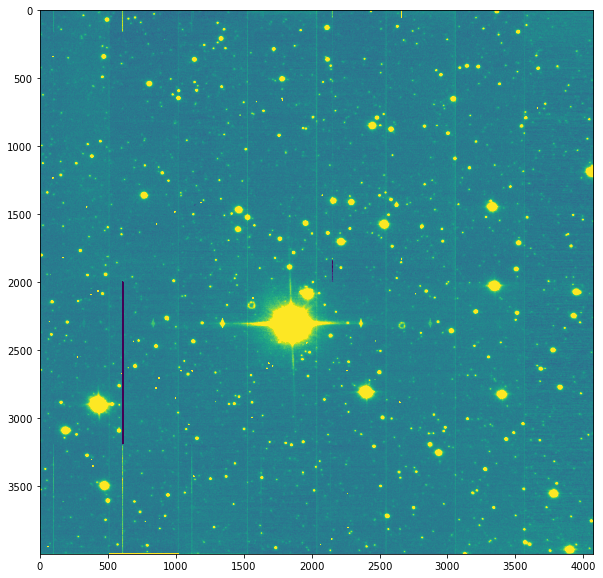

In [11]:
plt.figure(figsize=(10,10))
data = postIsr.image.array
plt.imshow(data, vmin=np.percentile(data, 2),vmax=np.percentile(data, 98))

In [12]:
from lsst.rapid.analysis.imageExaminer import ImageExaminer

In [13]:
imExam = ImageExaminer(postIsr)

quickFrameMeasurementTask INFO: Found 80 sources in exposure
quickFrameMeasurementTask INFO: Measured 80 of 80 sources in exposure


Using CoM for centroid (because was forced to, or multiple max pixels, or saturated
Centroid adjusted by [1.06949629 2.55118894] pixels


In [14]:
%matplotlib inline

Contoured from 251 to 50,068 using 10 contours of 5535.1


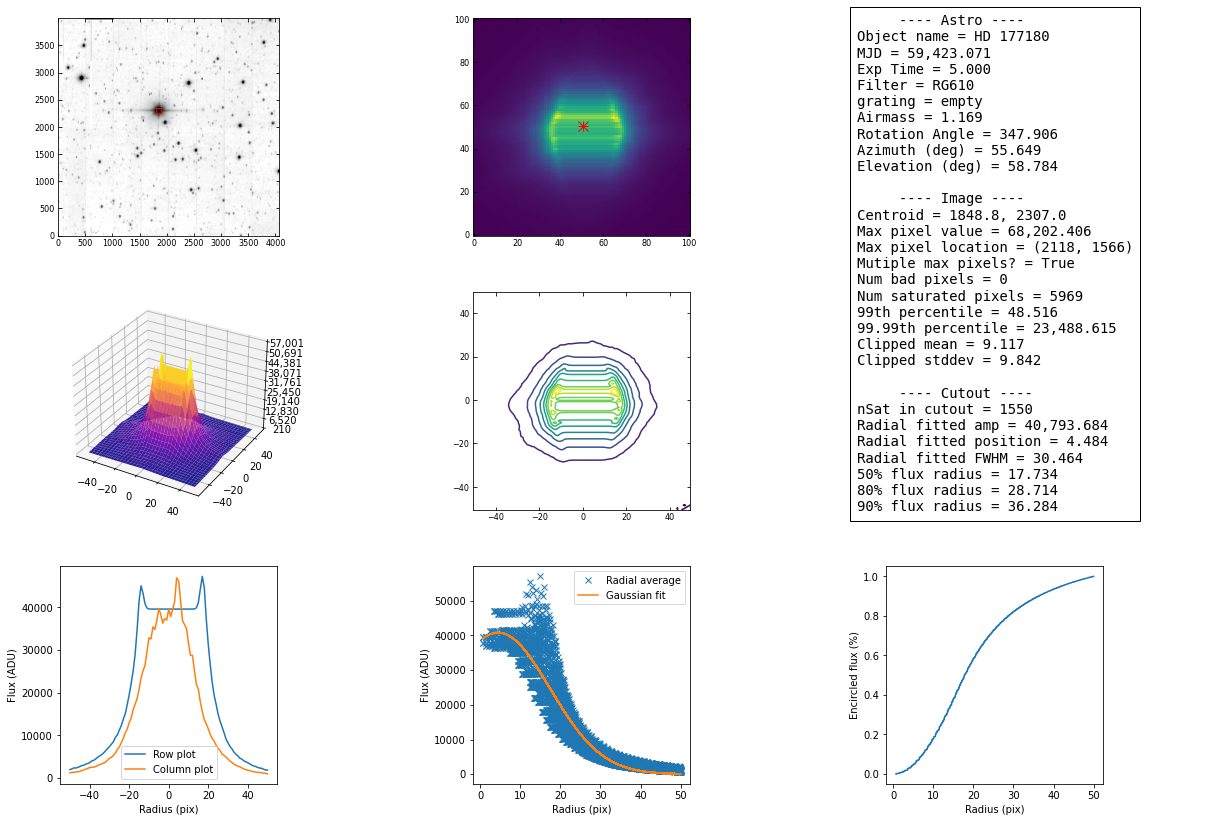

In [15]:
imExam.plot()

quickFrameMeasurementTask INFO: Found 18 sources in exposure
quickFrameMeasurementTask INFO: Measured 18 of 18 sources in exposure


Centroid adjusted by [1 0] pixels
Contoured from -15 to 2,256 using 10 contours of 252.3


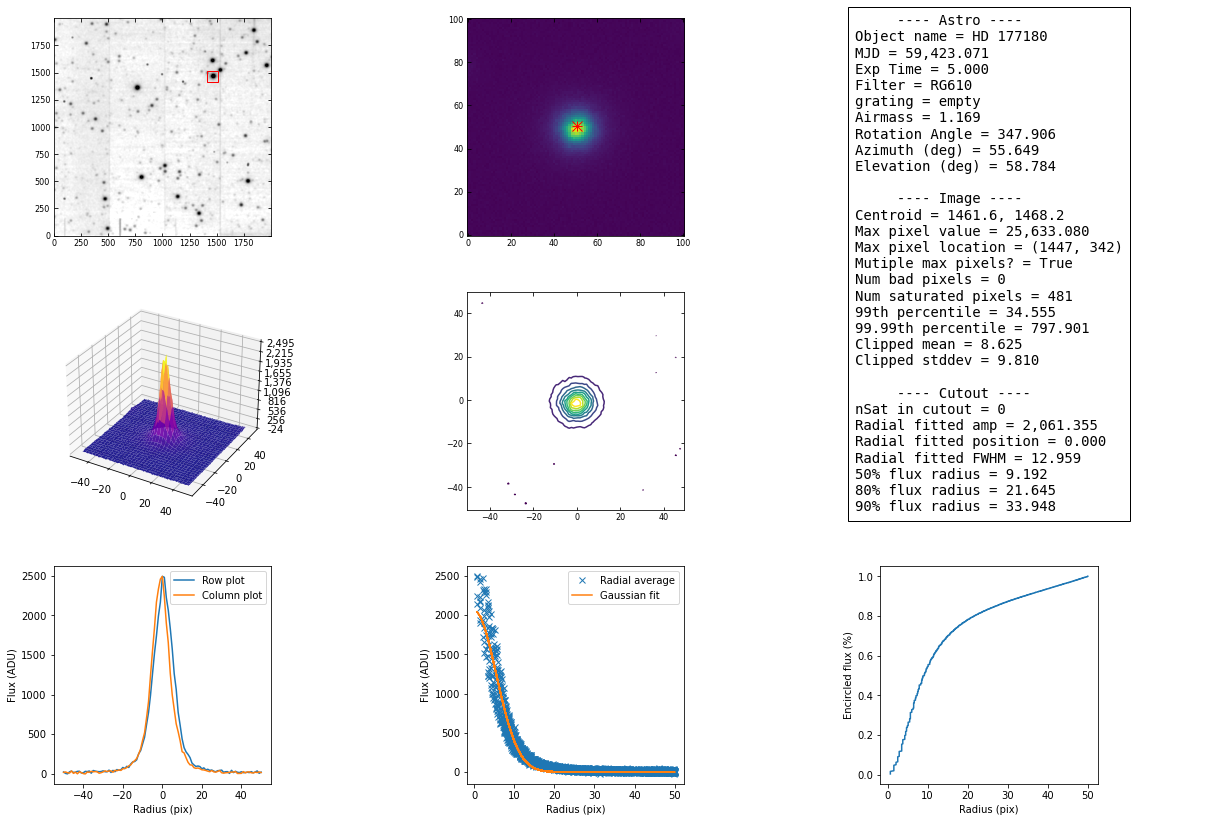

In [16]:
imExam = ImageExaminer(postIsr[0:2000, 0:2000])
imExam.plot()

In [17]:
postIsr.mask.getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 9}

In [18]:
postIsr.mask[2000,2000]

0

In [19]:
postIsr.mask.interpret(postIsr.mask[1848,2307])

'DETECTED,INTRP,SAT'

In [20]:
md = postIsr.getMetadata()

In [21]:
md.toDict()

{'SIMPLE': True,
 'EXTEND': True,
 'COMMENT': ["  FITS (Flexible Image Transport System) format is defined in 'Astronomy",
  "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H",
  "= '        '",
  '---- Date, night and basic image information ----',
  "= '        '",
  '---- Telescope info, location, observer ----',
  "= '        '",
  '---- Pointing info, etc. ----',
  "= '        '",
  '---- TAN Projection ----',
  "= '        '",
  '---- Image-identifying used to build OBS-ID ----',
  "= '        '",
  '---- Test Stand information ----',
  "= '        '",
  '---- Information from Camera (Common block) ----',
  "= '        '",
  '---- Information from Camera ----',
  "= '        '",
  '---- Filter/grating information ----',
  "= '        '",
  '---- Exposure-related information ----',
  "= '        '",
  '---- Weather information ----',
  "= '        '",
  '---- Header information ----',
  "= '        '",
  '---- Checksums ----',
  '---- Information from Camera

In [22]:
info = postIsr.getInfo()

In [23]:
from astro_metadata_translator import ObservationInfo

In [24]:
obsInfo = ObservationInfo(postIsr.getMetadata())

In [25]:
obsInfo.boresight_airmass

1.16878440448218

In [26]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask

In [27]:
imCharTask = CharacterizeImageTask()

In [28]:
imCharTask.run(postIsr)

characterizeImage INFO: PSF estimation initialized with 'simple' PSF
characterizeImage.repair INFO: Identified 65 cosmic rays.
characterizeImage.detection INFO: Detected 453 positive peaks in 185 footprints and 58 negative peaks in 1 footprints to 50 sigma
characterizeImage.detection INFO: Resubtracting the background after object detection
characterizeImage.measurement INFO: Measuring 185 sources (185 parents, 0 children) 
characterizeImage.measurePsf INFO: Measuring PSF
characterizeImage.measurePsf INFO: PSF star selector found 74 candidates
characterizeImage.measurePsf.reserve INFO: Reserved 0/74 sources
characterizeImage.measurePsf INFO: Sending 74 candidates to PSF determiner
characterizeImage.measurePsf.psfDeterminer WARNING: NOT scaling kernelSize by stellar quadrupole moment, but using absolute value
characterizeImage.measurePsf INFO: PSF determination using 52/74 stars.
characterizeImage INFO: iter 1; PSF sigma=5.04, dimensions=(41, 41); median background=8.58
characterizeImag

Struct(exposure=<lsst.afw.image.exposure.ExposureF object at 0x7f6eb7763f70>; sourceCat= id coord_ra ... base_ClassificationExtendedness_flag base_FootprintArea_value
      rad    ...                                                pix           
--- -------- ... ------------------------------------ ------------------------
  1      nan ...                                 True                     2178
  2      nan ...                                False                     5017
  3      nan ...                                False                     2735
  4      nan ...                                False                     5122
  5      nan ...                                False                     3641
  6      nan ...                                False                     5972
  7      nan ...                                False                     3577
  8      nan ...                                False                     5217
  9      nan ...                           

In [29]:
psf = postIsr.getPsf()

In [30]:
kernelImage = psf.computeKernelImage()

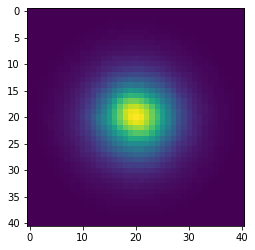

In [31]:
plt.imshow(kernelImage.array)

In [32]:
psf.computeShape()

Quadrupole(ixx=26.46883255360662, iyy=23.546609721170096, ixy=0.5620719524124113)

In [33]:
shape = psf.computeShape()

In [34]:
shape.getDeterminantRadius()*2.355*0.097

1.141230550301993

In [35]:
from lsst.geom import Point2D

In [36]:
psf.computeShape(position=Point2D(123.4,234.5))

Quadrupole(ixx=31.302109783141052, iyy=23.395557645875833, ixy=2.8661218452708668)